### DAY 5

### Oil & Gas Data Research, Web Scraping and Analysis

### Business Problem
Oil Price Crash Exposure by Country (2010–2023)

Which countries are most exposed to oil price crashes? (if oil prices drop sharply, which economies get hit the hardest (growth, budget, FX reserves, jobs, etc)

### DataSets I Need:

A. Oil dependence indicators (World Bank)
   - Oil rents (% of GDP)
   - Fuel exports (% of merchandise exports)
     
B. Oil price series
   - Brent crude price time series

In [1]:
import pandas as pd
import requests

I accessed oil dependence data directly from the **World Bank using its public API**. 
The API URL was constructed with the specific indicator code for *Oil rents (% of GDP)* (`NY.GDP.PETR.RT.ZS`) and configured to return the data in JSON format for all countries. Using the `requests` library, this URL allows me to programmatically retrieve the raw data instead of manually downloading it from the website. This ensures the data is official, up to date, and suitable for automated analysis.


In [4]:
url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PETR.RT.ZS?format=json&per_page=20000"

r = requests.get(url)

print(r.status_code)


200


### Data Cleaning

We convert the response to JSON first because the World Bank API returns data in JSON format, and Pandas needs the data as structured Python objects (lists/dictionaries) before it can be converted into a DataFrame.

In [6]:
data = r.json()
type(data), len(data)

(list, 2)

Meaning:

data[0] = metadata (page info)

data[1] = the actual rows

Let's Look at one row

In [10]:
data[1][0]

{'indicator': {'id': 'NY.GDP.PETR.RT.ZS', 'value': 'Oil rents (% of GDP)'},
 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'},
 'countryiso3code': 'AFE',
 'date': '2024',
 'value': None,
 'unit': '',
 'obs_status': '',
 'decimal': 1}

Convert the JSON rows to a DataFrame

In [13]:
df_oil = pd.json_normalize(data[1])
df_oil.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,AFE,2024,NaN,,,1,NY.GDP.PETR.RT.ZS,Oil rents (% of GDP),ZH,Africa Eastern and Southern
1,AFE,2023,NaN,,,1,NY.GDP.PETR.RT.ZS,Oil rents (% of GDP),ZH,Africa Eastern and Southern
2,AFE,2022,NaN,,,1,NY.GDP.PETR.RT.ZS,Oil rents (% of GDP),ZH,Africa Eastern and Southern
3,AFE,2021,2.324440,,,1,NY.GDP.PETR.RT.ZS,Oil rents (% of GDP),ZH,Africa Eastern and Southern
4,AFE,2020,1.326026,,,1,NY.GDP.PETR.RT.ZS,Oil rents (% of GDP),ZH,Africa Eastern and Southern


Let's Keep only the columns we need

In [16]:
df_oil_clean = df_oil[["country.value", "countryiso3code", "date", "value"]].copy()

df_oil_clean = df_oil_clean.rename(columns={
    "country.value": "country",
    "countryiso3code": "country_code",
    "date": "year",
    "value": "oil_rents_pct_gdp"
})

df_oil_clean.head()

,country,country_code,year,oil_rents_pct_gdp
0,Africa Eastern and Southern,AFE,2024,NaN
1,Africa Eastern and Southern,AFE,2023,NaN
2,Africa Eastern and Southern,AFE,2022,NaN
3,Africa Eastern and Southern,AFE,2021,2.324440
4,Africa Eastern and Southern,AFE,2020,1.326026


Convert year/value to numbers and filter 2010–2023

In [19]:
df_oil_clean["year"] = pd.to_numeric(df_oil_clean["year"], errors="coerce")
df_oil_clean["oil_rents_pct_gdp"] = pd.to_numeric(df_oil_clean["oil_rents_pct_gdp"], errors="coerce")

df_oil_clean = df_oil_clean[(df_oil_clean["year"] >= 2010) & (df_oil_clean["year"] <= 2023)]
df_oil_clean.head()

,country,country_code,year,oil_rents_pct_gdp
1,Africa Eastern and Southern,AFE,2023,NaN
2,Africa Eastern and Southern,AFE,2022,NaN
3,Africa Eastern and Southern,AFE,2021,2.324440
4,Africa Eastern and Southern,AFE,2020,1.326026
5,Africa Eastern and Southern,AFE,2019,2.468533


In [21]:
df_oil_clean[df_oil_clean["year"].isin([2022, 2023])]["oil_rents_pct_gdp"].isna().mean()

1.0

Since oil rents data for 2022 and 2023 is largely missing, those years will be  excluded from the analysis. 

The dataset will therefore restricted to the period 2010–2021 to ensure completeness and consistency across countries.

In [24]:
df_oil_clean = df_oil_clean[df_oil_clean["year"] <= 2021].copy()

In [26]:
df_oil_clean

,country,country_code,year,oil_rents_pct_gdp
3,Africa Eastern and Southern,AFE,2021,2.324440
4,Africa Eastern and Southern,AFE,2020,1.326026
5,Africa Eastern and Southern,AFE,2019,2.468533
6,Africa Eastern and Southern,AFE,2018,3.020676
7,Africa Eastern and Southern,AFE,2017,2.325342
...,...,...,...,...
17235,Zimbabwe,ZWE,2014,0.062337
17236,Zimbabwe,ZWE,2013,0.004607
17237,Zimbabwe,ZWE,2012,0.017659
17238,Zimbabwe,ZWE,2011,0.000000


Let's Filter the dataset to have only Real Countries

In [29]:
url_countries = "https://api.worldbank.org/v2/country?format=json&per_page=400"
countries_json = requests.get(url_countries).json()

countries_df = pd.json_normalize(countries_json[1])

real_countries = countries_df[countries_df["region.value"] != "Aggregates"]["id"].tolist()

len(real_countries), real_countries[:10]


(217, ['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG'])

In [31]:
df_oil_clean = df_oil_clean[df_oil_clean["country_code"].isin(real_countries)].copy()
df_oil_clean.head()

,country,country_code,year,oil_rents_pct_gdp
3188,Afghanistan,AFG,2021,0.017870
3189,Afghanistan,AFG,2020,0.005178
3190,Afghanistan,AFG,2019,0.012777
3191,Afghanistan,AFG,2018,0.018854
3192,Afghanistan,AFG,2017,0.013427


Now we repeat the same process for the second indicator:

- Fuel exports (% of merchandise exports)
- Indicator code: TX.VAL.FUEL.ZS.UN

In [34]:
url_fuel = "https://api.worldbank.org/v2/country/all/indicator/TX.VAL.FUEL.ZS.UN?format=json&per_page=20000"
print(url_fuel)

r_fuel = requests.get(url_fuel)
r_fuel.status_code

https://api.worldbank.org/v2/country/all/indicator/TX.VAL.FUEL.ZS.UN?format=json&per_page=20000


200

In [35]:
data_fuel = r_fuel.json()
type(data_fuel), len(data_fuel)

data_fuel[1][0]

{'indicator': {'id': 'TX.VAL.FUEL.ZS.UN',
  'value': 'Fuel exports (% of merchandise exports)'},
 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'},
 'countryiso3code': 'AFE',
 'date': '2024',
 'value': 27.8139418527015,
 'unit': '',
 'obs_status': '',
 'decimal': 0}

In [36]:
df_fuel = pd.json_normalize(data_fuel[1])
df_fuel.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,AFE,2024,27.813942,,,0,TX.VAL.FUEL.ZS.UN,Fuel exports (% of merchandise exports),ZH,Africa Eastern and Southern
1,AFE,2023,25.404542,,,0,TX.VAL.FUEL.ZS.UN,Fuel exports (% of merchandise exports),ZH,Africa Eastern and Southern
2,AFE,2022,27.005103,,,0,TX.VAL.FUEL.ZS.UN,Fuel exports (% of merchandise exports),ZH,Africa Eastern and Southern
3,AFE,2021,23.711281,,,0,TX.VAL.FUEL.ZS.UN,Fuel exports (% of merchandise exports),ZH,Africa Eastern and Southern
4,AFE,2020,23.344011,,,0,TX.VAL.FUEL.ZS.UN,Fuel exports (% of merchandise exports),ZH,Africa Eastern and Southern


In [40]:
df_fuel_clean = df_fuel[["country.value", "countryiso3code", "date", "value"]].copy()

df_fuel_clean = df_fuel_clean.rename(columns={
    "country.value": "country",
    "countryiso3code": "country_code",
    "date": "year",
    "value": "fuel_exports_pct"
})

df_fuel_clean.head()

,country,country_code,year,fuel_exports_pct
0,Africa Eastern and Southern,AFE,2024,27.813942
1,Africa Eastern and Southern,AFE,2023,25.404542
2,Africa Eastern and Southern,AFE,2022,27.005103
3,Africa Eastern and Southern,AFE,2021,23.711281
4,Africa Eastern and Southern,AFE,2020,23.344011


In [42]:
df_fuel_clean["year"] = pd.to_numeric(df_fuel_clean["year"], errors="coerce")
df_fuel_clean["fuel_exports_pct"] = pd.to_numeric(df_fuel_clean["fuel_exports_pct"], errors="coerce")

df_fuel_clean = df_fuel_clean[(df_fuel_clean["year"] >= 2010) & (df_fuel_clean["year"] <= 2021)]
df_fuel_clean.head()

,country,country_code,year,fuel_exports_pct
3,Africa Eastern and Southern,AFE,2021,23.711281
4,Africa Eastern and Southern,AFE,2020,23.344011
5,Africa Eastern and Southern,AFE,2019,24.861651
6,Africa Eastern and Southern,AFE,2018,24.868596
7,Africa Eastern and Southern,AFE,2017,25.325806


In [44]:
df_fuel_clean = df_fuel_clean[df_fuel_clean["country_code"].isin(real_countries)].copy()
df_fuel_clean.head()

,country,country_code,year,fuel_exports_pct
3188,Afghanistan,AFG,2021,NaN
3189,Afghanistan,AFG,2020,NaN
3190,Afghanistan,AFG,2019,8.051279
3191,Afghanistan,AFG,2018,10.213181
3192,Afghanistan,AFG,2017,5.234428


Let's Check for Missing Values

In [47]:
df_fuel_clean.isnull().sum()

country               0
country_code          0
year                  0
fuel_exports_pct    621
dtype: int64

In [49]:
df_oil_clean.isnull().sum()

country                0
country_code           0
year                   0
oil_rents_pct_gdp    255
dtype: int64

### Merge the two datasets

### Handling Missing Values


In [52]:
df_merged = pd.merge(
    df_oil_clean,
    df_fuel_clean,
    on=["country", "country_code", "year"],
    how="inner"
)

df_merged.head()

,country,country_code,year,oil_rents_pct_gdp,fuel_exports_pct
0,Afghanistan,AFG,2021,0.017870,NaN
1,Afghanistan,AFG,2020,0.005178,NaN
2,Afghanistan,AFG,2019,0.012777,8.051279
3,Afghanistan,AFG,2018,0.018854,10.213181
4,Afghanistan,AFG,2017,0.013427,5.234428


I Used inner merge to keep only country-year records present in both datasets. 

However, some matched rows still contained missing indicator values because the merge condition applies only to the country-year keys, not to the indicator values. 

In [55]:
df_merged = df_merged.dropna(subset=["oil_rents_pct_gdp", "fuel_exports_pct"]).copy()

Therefore, rows with missing oil rents or fuel export values were removed after merging to ensure a complete dataset.

In [58]:
df_merged.isnull().sum()

country              0
country_code         0
year                 0
oil_rents_pct_gdp    0
fuel_exports_pct     0
dtype: int64

In [60]:
df_merged.to_csv("Oil_pct_and_fuel_pct.csv", index=False)

### DAY 6

### To Answer Business Question

#### Normalize the two indicators (year by year)

**Why normalize?**
Because oil rents might range 0–60, while fuel exports ranges 0–100.
Normalization puts them on the same scale (0 to 1) so we can combine them fairly.

In [65]:
import numpy as np

def minmax(s):
    return (s - s.min()) / (s.max() - s.min())

df_merged["norm_oil_rents"] = df_merged.groupby("year")["oil_rents_pct_gdp"].transform(minmax)
df_merged["norm_fuel_exports"] = df_merged.groupby("year")["fuel_exports_pct"].transform(minmax)

df_merged[["country","year","oil_rents_pct_gdp","fuel_exports_pct","norm_oil_rents","norm_fuel_exports"]].head()


,country,year,oil_rents_pct_gdp,fuel_exports_pct,norm_oil_rents,norm_fuel_exports
2,Afghanistan,2019,0.012777,8.051279,0.000331,0.084529
3,Afghanistan,2018,0.018854,10.213181,0.000428,0.106752
4,Afghanistan,2017,0.013427,5.234428,0.000373,0.054462
6,Afghanistan,2015,0.013636,3.450456,0.000366,0.034578
12,Albania,2021,1.042184,0.023915,0.030311,0.000254


What this does:

For each year separately, it scales values:

lowest country in that year → 0

highest country in that year → 1

everyone else → between 0 and 1

#### Calculate the Exposure Score

We’ll use a simple and defendable weighting:

- 60% weight on oil rents % GDP (economic dependence)

- 40% weight on fuel exports % (foreign exchange dependence)

In [69]:
df_merged["exposure_score"] = 0.6 * df_merged["norm_oil_rents"] + 0.4 * df_merged["norm_fuel_exports"]

df_merged[["country","year","exposure_score"]].head()

,country,year,exposure_score
2,Afghanistan,2019,0.034010
3,Afghanistan,2018,0.042957
4,Afghanistan,2017,0.022009
6,Afghanistan,2015,0.014051
12,Albania,2021,0.018288


Now I have a score between:

- 0 (low exposure)
- 1 (very high exposure)

I will Create a 2021 ranking table (latest complete year)
This will give me “Top 15 most exposed countries in 2021"

In [73]:
rank_2021 = df_merged[df_merged["year"] == 2021].copy()
rank_2021 = rank_2021.sort_values("exposure_score", ascending=False)

rank_2021[["country","oil_rents_pct_gdp","fuel_exports_pct","exposure_score"]].head(15)


,country,oil_rents_pct_gdp,fuel_exports_pct,exposure_score
60,Angola,28.274440,94.163746,0.893404
540,"Congo, Rep.",34.382881,55.090430,0.834020
144,Azerbaijan,20.983375,88.407449,0.741719
1992,Saudi Arabia,23.686294,76.607697,0.738762
1776,Oman,23.538744,65.285584,0.688092
996,Guyana,22.082175,68.945819,0.678222
1908,Qatar,15.278467,84.403897,0.625159
2448,United Arab Emirates,15.673095,70.321985,0.572226
1200,Kazakhstan,14.844802,65.610873,0.537760
1092,"Iran, Islamic Rep.",18.265898,47.911953,0.522276


Add risk buckets (High / Medium / Low)

In [76]:
rank_2021["risk_bucket"] = pd.qcut(rank_2021["exposure_score"], q=3, labels=["Low", "Medium", "High"])
rank_2021[["country","exposure_score","risk_bucket"]].head(15)


,country,exposure_score,risk_bucket
60,Angola,0.893404,High
540,"Congo, Rep.",0.834020,High
144,Azerbaijan,0.741719,High
1992,Saudi Arabia,0.738762,High
1776,Oman,0.688092,High
996,Guyana,0.678222,High
1908,Qatar,0.625159,High
2448,United Arab Emirates,0.572226,High
1200,Kazakhstan,0.537760,High
1092,"Iran, Islamic Rep.",0.522276,High


In [78]:
df_merged.to_csv("oil_exposure_country_year_2010_2021.csv", index=False)
rank_2021.to_csv("oil_exposure_ranking_2021.csv", index=False)

A country gets a high exposure score if:

- oil rents are high (oil is a big part of GDP)
AND/OR
- fuel exports are high (oil/fuel dominates exports)

In [81]:
rank_2021[["country","exposure_score"]].head(10)

,country,exposure_score
60,Angola,0.893404
540,"Congo, Rep.",0.834020
144,Azerbaijan,0.741719
1992,Saudi Arabia,0.738762
1776,Oman,0.688092
996,Guyana,0.678222
1908,Qatar,0.625159
2448,United Arab Emirates,0.572226
1200,Kazakhstan,0.537760
1092,"Iran, Islamic Rep.",0.522276


These countries are ranked highest because (in 2021):

- Oil rents (% of GDP) are high → oil is a big part of the economy and/or
- Fuel exports (% of exports) are high → oil/fuels drive foreign-currency earnings

So they’re the most vulnerable when oil prices fall.

Insights:

- **Angola and Congo (Rep.)** are extremely exposed **(very close to 1.0)**. This usually happens when oil is both a major export and a big GDP contributor.

- The list is dominated by oil-exporting economies **(Saudi Arabia, Oman, Qatar, UAE, Kazakhstan, Iran)**, which makes sense—these countries are structurally tied to oil revenue.

- **Guyana** appearing high is a classic **“small base / new producer”** story: when oil becomes a big share quickly, exposure scores rise fast.

- **Azerbaijan and Kazakhstan** show that exposure is also strong in some Eurasian exporters, not only the Middle East/Africa.

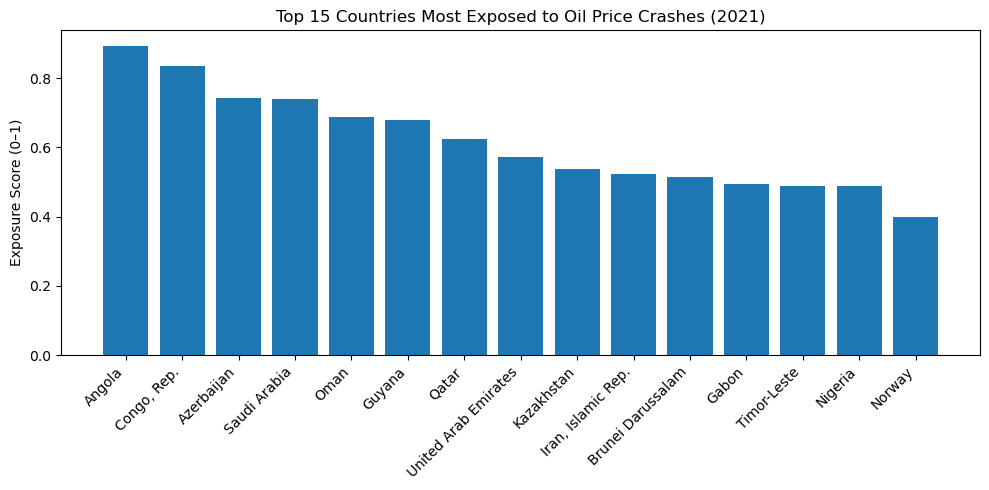

In [86]:
import matplotlib.pyplot as plt

top15 = rank_2021.sort_values("exposure_score", ascending=False).head(15)

plt.figure(figsize=(10,5))
plt.bar(top15["country"], top15["exposure_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Exposure Score (0–1)")
plt.title("Top 15 Countries Most Exposed to Oil Price Crashes (2021)")
plt.tight_layout()
plt.show()

**In 2021, Angola and Congo (Rep.)** ranked as the most exposed economies, reflecting high dependence on oil for GDP and/or exports. 
**Middle East exporters (Saudi Arabia, Oman, Qatar, UAE)** also remain high-risk due to strong export dependence.

Scatter: GDP dependence vs Export dependence (2021)

This is going to explain why they’re high.

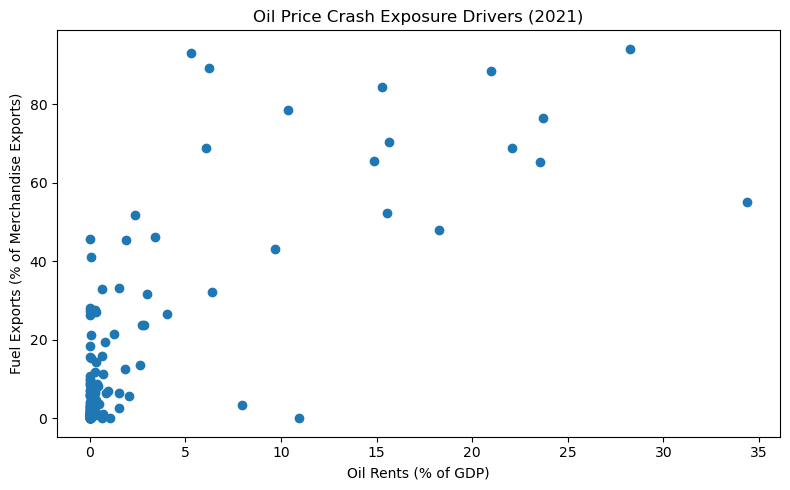

In [93]:
plt.figure(figsize=(8,5))
plt.scatter(rank_2021["oil_rents_pct_gdp"], rank_2021["fuel_exports_pct"])
plt.xlabel("Oil Rents (% of GDP)")
plt.ylabel("Fuel Exports (% of Merchandise Exports)")
plt.title("Oil Price Crash Exposure Drivers (2021)")
plt.tight_layout()
plt.show()

Key insights:

1. Countries in the top-right corner are the most vulnerable.

These countries have both:
- high oil rents as a share of GDP (their economies depend on oil), and
- high fuel exports as a share of total exports (their foreign currency depends on oil).
This combination makes them highly exposed to oil price crashes because both government revenue and export earnings fall when oil prices decline.

2. Some countries show high export dependence but lower GDP dependence.
These appear high on the vertical axis but more to the left horizontally.
This suggests that while oil dominates their exports, it is not the main driver of their entire economy. These countries face strong foreign exchange risk during oil price crashes even if GDP impact is smaller.

3. Some countries have high GDP dependence but more diversified exports.
These appear far to the right but lower vertically.
This indicates that oil contributes heavily to domestic income, but exports are more diversified. These countries are vulnerable through fiscal and budget channels rather than trade channels.

4. Most countries cluster in the lower-left region.
This cluster represents countries with:
- low oil rents in GDP, and
- low fuel export shares.
These economies are relatively insulated from oil price crashes and are more resilient to oil market volatility.

5. The scatter shows that exposure is driven by two different mechanisms.
The chart demonstrates that vulnerability to oil price crashes is not caused by one factor alone. Instead, risk arises from:
- dependence on oil for national income (GDP channel), and
- dependence on oil for export revenue (trade channel).
Countries that score high on both dimensions face the greatest macroeconomic risk.


Countries that rely heavily on oil for both economic output and export earnings face the greatest vulnerability to oil price crashes, while countries with diversified economies and exports are far more resilient.

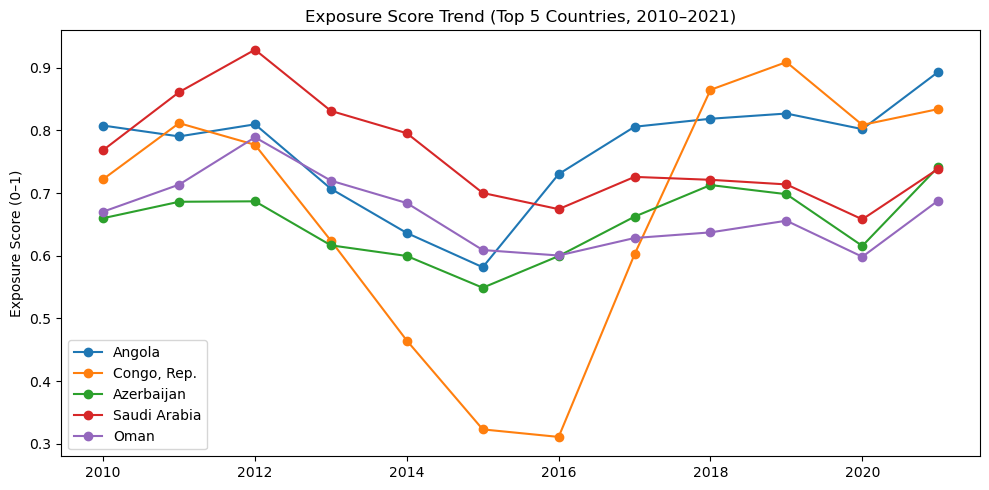

In [96]:
top5_countries = top15["country"].head(5).tolist()
df_top5 = df_merged[df_merged["country"].isin(top5_countries)].copy()

plt.figure(figsize=(10,5))
for c in top5_countries:
    tmp = df_top5[df_top5["country"] == c].sort_values("year")
    plt.plot(tmp["year"], tmp["exposure_score"], marker="o", label=c)

plt.ylabel("Exposure Score (0–1)")
plt.title("Exposure Score Trend (Top 5 Countries, 2010–2021)")
plt.legend()
plt.tight_layout()
plt.show()


##### Exposure Score Trend (Top 5 Countries, 2010–2021)
**Key insights:**

1. All five countries remain consistently highly exposed over the entire period.
Their exposure scores stay mostly above 0.6, indicating that oil dependence is structural, not temporary. These economies have not significantly diversified away from oil during this period.

2. **Saudi Arabia shows the highest exposure in the early 2010s, followed by a gradual decline.**
Exposure peaks around 2012–2013 and then trends downward, suggesting some reduction in oil dependence over time, possibly linked to diversification efforts and economic reforms.

3. **Congo (Rep.) exhibits the most volatility in exposure.**
Its exposure score drops sharply **between 2013 and 2016**, then rebounds strongly after 2017. This suggests that its vulnerability is highly sensitive to changes in oil production levels and export structure.

4. **Angola’s exposure declines after 2012 but rises again after 2016.**
This pattern indicates periods of partial diversification followed by renewed dependence, showing that progress in reducing exposure has not been sustained.

5. **Azerbaijan and Oman show moderate but persistent exposure levels.**
Their exposure scores fluctuate within a narrower band, suggesting gradual adjustments rather than abrupt structural changes in oil dependence.

6. **The period around 2014–2016 coincides with the global oil price crash and is associated with declining exposure for several countries.**
This likely reflects reduced oil rents and export values during the crash, which temporarily lowered measured exposure rather than indicating true economic diversification.

Despite fluctuations linked to oil price cycles, the most exposed countries have remained structurally dependent on oil between 2010 and 2021, with only limited evidence of sustained diversification.

In [98]:
pre = df_merged[df_merged["year"].between(2011, 2013)].groupby("country")["exposure_score"].mean()
crash = df_merged[df_merged["year"] == 2020].groupby("country")["exposure_score"].mean()

compare = pd.concat([pre, crash], axis=1)
compare.columns = ["avg_2011_2013", "score_2020"]
compare = compare.dropna()
compare["change"] = compare["score_2020"] - compare["avg_2011_2013"]

compare.sort_values("change", ascending=False).head(10)

,avg_2011_2013,score_2020,change
country,,,
Guyana,6.133470e-08,0.337779,0.337779
Papua New Guinea,5.998032e-02,0.196882,0.136901
"Bahamas, The",2.698019e-06,0.121450,0.121447
Cyprus,1.066749e-04,0.085729,0.085622
"Congo, Rep.",7.375588e-01,0.808758,0.071199
Lao PDR,2.753396e-03,0.072144,0.069390
Mozambique,1.062473e-01,0.158708,0.052460
Seychelles,2.907071e-03,0.048789,0.045882
Angola,7.689906e-01,0.802037,0.033046


What this table means:
- avg_2011_2013 = each country’s average exposure score before the big oil crash period (baseline)

- score_2020 = the country’s exposure score during the COVID oil shock year

- change = score_2020 - avg_2011_2013
→ Positive means the country became more exposed by 2020.


1) The biggest “jump” is Guyana

- Guyana went from almost zero exposure in 2011–2013 (basically not oil-dependent then) to a much higher exposure in 2020 (+0.338)
Guyana is a classic example of a country that became oil-dependent quickly in recent years as oil production and exports expanded.

**Insight:**
Guyana shows the largest increase in exposure, indicating a rapid transition from low oil dependence in the early 2010s to significantly higher vulnerability by 2020.

2) Several countries increased exposure from a low base (new or expanding oil/gas economies)

Examples:
- Papua New Guinea
- Mozambique
- Lao PDR (smaller but rising)
These countries likely increased fuel-export reliance or resource rents over time, making them more sensitive to price shocks.

**Insight:**
Several countries with low baseline exposure experienced meaningful increases by 2020, suggesting rising dependence on fuel exports and resource rents over the decade.

3) Congo (Rep.) and Angola stayed highly exposed — and still increased

- Congo (Rep.): 0.737 → 0.809 (+0.071)
- Angola: 0.769 → 0.802 (+0.033)
These were already high-risk countries, and by 2020 they remained deeply vulnerable — meaning structural dependence persisted.

**Insight:**
Already highly oil-dependent economies such as Congo (Rep.) and Angola remained strongly exposed, and their exposure increased further by 2020, indicating limited diversification.

4) Some surprising names may be due to data dynamics (not “oil producers”)

Countries like:
- Bahamas
- Cyprus
- Seychelles
- Kenya

These may appear because:
- fuel exports share can shift due to trade composition changes, re-exports, or reporting structure 
- and normalization compares countries within a year, so changes can reflect relative movement

**Insight:**
Some non-traditional oil economies appear in the results, which may reflect shifts in trade composition or reporting effects rather than true oil production dependence; these should be flagged for interpretation.

Comparing the pre-crash baseline (2011–2013) to the COVID oil shock year (2020), countries such as Guyana and Papua New Guinea showed the largest increases in exposure, indicating rising dependence on oil-related income and fuel export revenue over the decade. Meanwhile, structurally oil-dependent economies like Congo (Rep.) and Angola remained highly exposed and increased further, suggesting limited diversification. Some smaller economies appearing in the ranking may reflect changes in trade composition or data reporting and should be interpreted cautiously.

To reduce “small base effects,” I filtered the pre-crash baseline results to include only countries with an average exposure score above 0.2 in 2011–2013. 

This focuses the comparison on countries that were already meaningfully oil-dependent before 2020.

In [107]:
compare_filtered = compare[compare["avg_2011_2013"] > 0.2].copy()
compare_filtered = compare_filtered.sort_values("change", ascending=False)

compare_filtered.head(15)


,avg_2011_2013,score_2020,change
country,,,
"Congo, Rep.",0.737559,0.808758,0.071199
Angola,0.768991,0.802037,0.033046
United Arab Emirates,0.510874,0.533847,0.022973
Cameroon,0.204038,0.222949,0.018911
Kuwait,0.978922,0.997294,0.018373
Kazakhstan,0.468326,0.434715,-0.033611
Nigeria,0.489989,0.451475,-0.038514
Azerbaijan,0.663209,0.615704,-0.047505
Norway,0.346338,0.281218,-0.065120


After filtering to countries with meaningful baseline exposure **(avg score > 0.2 in 2011–2013)**, the largest increases by 2020 were observed in **Congo (Rep.) and Angola, indicating rising or persistent oil dependence and greater vulnerability to price crashes.** 

In contrast, several **major producers—including Qatar, Iran, Russia, Norway, and Nigeria—showed declines in exposure by 2020**, which may reflect diversification progress or temporary pandemic-related shifts in oil rents and export composition. 

Overall, the results suggest that while some economies remain structurally dependent on oil, others have reduced their sensitivity to oil price shocks over time.